In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
import csv
import copy as cp
import random as rand
import random as ra
from scipy.stats import pearsonr, linregress
from scipy.signal import detrend
from scipy.io import loadmat
from matplotlib import cm, colors
from numba import njit, vectorize
from numpy import save, load

In [2]:
#The interval of time we're looking at (1980 to 2010)
startyear = 1980
endyear = 2010
timeseries = np.arange(startyear, endyear + 1, 1) #yearly
timeseries_cont = np.arange(startyear, endyear + 1, 1/12) #monthly

#dictionary of months
monthsnum = np.arange(1,13,1)
monthsind = np.arange(0,12,1)
monthsstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthsnam = ['J','F','M','A','M','J','J','A','S','O','N','D']
months = {1:'January',2:'February',3:'March',
          4:'April',5:'May',6:'June',7:'July',8:'August',
          9:'September',10:'October',11:'November',12:'December'}
names = ['NSIDC','Had2CIS','CANCM4i','GEM_NEMO','COMBINED']

#colours for graphing
col = ['#7f00ff','#6000ff','#3a06f9','#0300ff','#004aff','#007eff',
       '#009fff','#00c3ff','#00dcff','#00fffe','#00ffd3','#19e67b']
col.reverse()

#Number of times for sampling with replacement
Nb = 2000

#regions
PanAntarctic = [0,360]
Weddell = [300,20]
Indian = [20,90]
WestPacific = [90,160]
Ross = [160,230]
Amundsen = [230,300]

In [3]:
#NON-COMPATIBLE WITH NUMBA

#Put a dictionary of data into a 1D array

def Dict1D (dataset):
    
    #put all the data into a 1D array
    
    dataset1D = []
    for year in dataset.keys():
        for im in monthsind:
            dataset1D.append(dataset[year][im])
    
    return np.asarray(dataset1D)


#function to retrieve data from .txt file

def retrievedat (filename, loc = "Region_PanAntarcticSIE", output_type = 'array'):
    '''
    retrieve dictionary data from a .txt file in a specific format
    '''
    
    #dictionary full of data to be returned
    datadict = {}
    
    f = open(loc + "/" + str(filename) + ".txt", "r")
    
    #go line by line
    for line in f:
        
        #split line into an array
        line.replace('\n', '')
        linearray = line.split()
        
        
        year = np.int64(linearray[0])
        dat = linearray[1:]
        
        if year >= startyear and year <= endyear:
            #convert nones to None and values to floats
            for i,d in enumerate(dat):
                if d == 'None':
                    dat[i] = np.nan
                else:
                    dat[i] = np.float64(d)

            datadict[year] = dat
    
    f.close()
    if output_type == 'array' or output_type == 'Array':
        return Dict1D(datadict)
    else:
        return datadict

#function to write data to .txt file

def writedat(yearlydata, filename):
    '''
    yearlydata: (dictionary) the data to be written to file, in the form of a dictionary
    filename: (string) the name of the file, excluding the .txt
    '''

    #First, create file
    #x is to create file
    #w is to rewrite file. If file doesn't exist, create file.
    #a is to append to file. If file doesn't exist, create file.
    #r is to read file

    f = open("Region_RossSIE/" + str(filename) + ".txt", "w")

    #go year by year
    for year in yearlydata.keys():

        f.write(str(year) + " ")

        #SIE month by month for the above year
        for val in yearlydata[year]:

            f.write(str(val) + " ")

        f.write("\n")

    f.close()

def Rearrange (array, N=0):
    """
    Take the first N elements of an array, delete them, then append them to the end.
    """
    
    if N == 0:
        
        return array
    
    else:
    
        section1 = array[0:N]
        section2 = array[N::]

        if type(array) == type([]):
            newarray = section2 + section1
        elif type(array) == type(np.arange(0,1)):
            newarray = np.concatenate((section2,section1))

        return newarray
    
def approximate_1st_of_month (a):
    '''
    Observations are for mid-month, and initialization conditions for the first day of the month. In order to form
    a better apples-to-apples comparison, we need to average each observation with the subsequent month's observation,
    in order to estimate the first-day observed SIE.
    e.g., [1,2,3,4] will become [1,1.5,2.5,3.5]
    e.g., [[1,2,3],[4,5,6]] will become [[1,1.5,2.5],[3.5,4.5,5.5]].
    '''
    
    a_new = np.zeros(np.shape(a))
    
    #case: 1D array
    if len(np.shape(a)) == 1:
        
        for i,el in enumerate(a):
            
            if i == 0:
                a_new[i] = a[i]
            
            if i == len(a)-1:
                pass
            
            else:
                a_new[i+1] = average([a[i],a[i+1]])
    
    
    #case: 2D array
    elif len(np.shape(a)) == 2:
        
        for i,dat_array in enumerate(a):
            for j,el in enumerate(dat_array):

                if i == 0 and j == 0:
                    a_new[i][j] = a[i][j]

                if i == len(a)-1 and j == len(dat_array)-1:
                    pass

                elif j == len(dat_array)-1:
                    a_new[i+1][0] = average([a[i][j],a[i+1][0]])

                else:
                    a_new[i][j+1] = average([a[i][j],a[i][j+1]])
                
    return a_new

def APF (dataset, lead0month):
    
    #return the anomaly persistance forecast dictionary for a given observational dataset, given an
    #initialization month (lead0month) from 1 to 12.
    
    #turn input data into 1d array if necessary
    if type(dataset) == dict:
        dataset = Dict1D(dataset)
    
    #anomaly persistence forecast dictionary
    datasetapf = {}
    for year in timeseries:
        datasetapf[year] = [np.nan]*12
    
    #calculate the means for each month across all years
    means = []
    for month in monthsnum:
        dataformonth = DataForMonth(dataset,month)
        means.append(average(dataformonth))  
               
    #The year for which the anomaly is being calculated & applied to
    for year in timeseries: 
        
        #if year != 1980: #because there's no data previous to 1980
            
            
            anomalyind = (lead0month - 1) - 1
            #real data for which the anomaly will be calculated from
            anomalydatapt = dataset[(year-startyear)*12 + anomalyind]
            
                
            #calculate anomaly from the mean for the particular year
            anomaly = anomalydatapt - means[anomalyind]

            #now use that anomaly to predict the succeeding eleven months
            for lead in monthsind:
                
                #target month
                targetmonthind = (lead0month - 1) + lead
                if targetmonthind >= 12:
                    targetmonthind -= 12
                
                datasetapf[year][lead] = means[targetmonthind] + anomaly

 
    return Dict1D(datasetapf)    
    
    
#Plot dots and triangles, representing significance
def Plot_Significance_Matrix (significance_matrix, axis_index):
    '''
    Assumes an axis on which to plot already exists.
    '''
    
    for j,row in enumerate(significance_matrix): #corresponds to leadtime
        for i,significance_value in enumerate(row): #corresponds to target month
            
            if significance_value == 1: #if signficant, plot a circular dot for that point
                
                if type(axis_index) == int:
                    axis[axis_index].scatter(i,j,marker=".", color='black')
                elif type(axis_index) == tuple:
                    axis[axis_index[0], axis_index[1]].scatter(i,j,marker=".", color='black')
                    
            elif significance_value == 2: #significant and exceeds APF
                
                if type(axis_index) == int:
                    axis[axis_index].scatter(i,j,marker="^", color='black')
                elif type(axis_index) == tuple:
                    axis[axis_index[0], axis_index[1]].scatter(i,j,marker="^", color='black')
                    
            elif significance_value < 0: #significant but negative
                
                if type(axis_index) == int:
                    axis[axis_index].scatter(i,j,marker="x", color='black')
                elif type(axis_index) == tuple:
                    axis[axis_index[0], axis_index[1]].scatter(i,j,marker="x", color='black')

In [4]:
#COMPATIBLE WITH NUMBA

#function to calculate sea ice extent from sea ice fraction/concentration

@njit
def calculate_SIE (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    region: an array with the two bounding longitudes that define the sector (e.g. [-30, 60])
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] < 0:
                
                #only consider a certain region
                if region[0] > region[1]:
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                else:
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
    return SIE_counter/1e6


#function to calculate average of array, numba-compatible
@njit
def average (array):
    
    net = 0.
    count = 0
    
    for dat in array:
        if np.isnan(dat) == False:
            net = net + dat
            count = count + 1
            
    if count != 0:
        return net/count
    else:
        return np.nan



#function to retrieve all data pertaining to a specific month of the year
@njit
def DataForMonth (dataset, month, initmonth = 1):

    #input must be a 1D array
            
    #Now pick out all the data corresponding to the specified month
    #e.g. if month = 1 and initmonth = 1, then it should pick out index 0, index 12, index 24, etc...
    
    index = (month - 1) - (initmonth - 1)
    dataset_for_month = np.full( int(len(dataset)/12), np.nan)

    if month < initmonth:
        index += 12

    index2 = 0 #index for the new array
    while index < len(dataset):
        dataset_for_month[index2] = dataset[index]
        index = index + 12 #jump forward 12 months
        index2 = index2 + 1
            
    return dataset_for_month

#fit a linear regression line
@njit
def Linear_Regression (data):
    
    #Returns the slope (m) and y intercept (b) for a linear regression line.
    #Assumes input data are evenly spaced, and there is no missing data.
    N = len(data)
    xaxis = np.arange(0,N)
    yaxis = data
    x_mean = average(xaxis)
    y_mean = average(yaxis)
    
    net1 = 0; net2 = 0 #variables to keep track of sum
    for i in range(N):
        
        #data pts
        x_i = xaxis[i]; y_i = yaxis[i]
        
        #sums
        net1 += (x_i - x_mean)*(y_i - y_mean)
        net2 += (x_i - x_mean)**2
    
    #slope and intercept
    m = net1/net2
    b = y_mean - m*x_mean
        
    #return answer
    return [m,b]

#remove a linear trend from data
@njit
def Remove_Trend (data, use_mitch_method = True):
    '''
    Make sure input array is floats and not ints, or else output will be wrong.
    
    Relies on custom functions:
    average, Linear_Regression
    '''
    if use_mitch_method == False: #regular detrending

        #copy input data
        data_new = np.copy(data)

        #if data set is small, just remove the mean
        if len(data_new) <= 3:

            data_new_mean = average(data_new)
            for i in range(len(data_new)):
                data_new[i] = data_new[i] - data_new_mean

        #else, calculate the linear trendline and remove it
        else:

            regression_params = Linear_Regression(data_new)
            slope = regression_params[0]; intercept = regression_params[1]
            print(slope,intercept)
            
            trendline = [slope*float(x) + intercept for x in range(len(data_new))]

            for i in range(len(data_new)):
                data_new[i] = data_new[i] - trendline[i]
        
        
    if use_mitch_method == True: #Mitch's detrending method
        
        #copy input data
        data_new = np.copy(data)
        
        for yrs in range(len(data)): #index variable running from 0 to len(data), used
                                     #for selecting the appropriate subset of years to apply Mitch's method to
        
            #copy input data again, but only select a subset
            data_new_subset = np.copy(data)[:yrs+1]

            #if data set is small, just remove the mean
            if len(data_new_subset) <= 3:

                data_new_mean = average(data_new_subset)
                for i in range(len(data_new_subset)):
                    data_new_subset[i] = data_new_subset[i] - data_new_mean

            #else, calculate the linear trendline and remove it
            else:

                regression_params = Linear_Regression(data_new_subset)
                slope = regression_params[0]; intercept = regression_params[1]

                trendline = [slope*float(x) + intercept for x in range(len(data_new_subset))]

                for i in range(len(data_new_subset)):
                    data_new_subset[i] = data_new_subset[i] - trendline[i]
            
            #put into array
            data_new[yrs] = data_new_subset[yrs]    
        
    return data_new


#Calculate anomaly correlation coefficient
@njit
def ACC (observation, prediction, month, initmonth, detrend = False, already_sorted = False):

    '''
    #specify initialization month of modelled data
    #choose month to be analyzed
    #month and initmonth range from 1 to 12, and are integers
    #observation and prediction input can be arrays or dictionaries
    
    Relies on custom functions:
    DataForMonth, average, Remove_Trend
    '''

    if already_sorted == False:
        #acquire data for the specified month, across all years
        o_array = DataForMonth(observation, month, 1)
        p_array = DataForMonth(prediction, month, initmonth)

        #if month < initmonth, need to account for the fact that the YEARS of the observational and
        #prediction data sets don't line up
        if month < initmonth:
            o_array = np.delete(o_array, 0)
            p_array = np.delete(p_array, -1)

    else:
        o_array = observation
        p_array = prediction
    
    #detrend if desired
    if detrend == True:
        o_array = Remove_Trend(np.asarray(o_array))
        p_array = Remove_Trend(np.asarray(p_array))

    return np.corrcoef(o_array,p_array)[0,1]

@njit
def ACC_matrix (observations, predictions_all, detrend=False):
    '''
    Input observations must be a 1D array
    Input "predictions_all" must be an array of 1D arrays:
    [(initmonth = Jan) array, (initmonth = Feb) array, etc.]
    Observations are simply a 1D array, or a dictionary
    
    Depends on custom functions:
    ACC
    '''
    
    #set up ACC matrix
    #columns are target month
    #rows are leadtime
    skill_matrix = np.full((12,12),np.nan)
    
    #populate ACC matrix
    for tm in monthsnum: 
        for lead in monthsind:
            
            #calculate corresponding initialization month
            im = tm - lead
            if im < 1:
                im = im + 12
            
            #acquire predictions for this leadtime
            predictions = predictions_all[im-1]
            
            #calculate the ACC
            skill = ACC(observations, predictions, tm, im, detrend=detrend)
            
            #Put in skill matrix
            skill_matrix[lead][tm-1] = skill
    
    return skill_matrix
    
    
#MODIFIED Statistical Significance Functions
#DON'T COPY THIS FUNCTION INTO OTHER NOTEBOOKS, IT WILL NOT WORK PROPERLY
@njit
def Bootstrap (data_obs, data_pred, nboot=Nb, detrend=False):
    
    #acquire appropriate subset of data
    data_obs_subset = np.asarray(data_obs)
    data_pred_subset = np.asarray(data_pred)
    
    #detrend
    if detrend==True:
        data_obs_subset = Remove_Trend(data_obs_subset)
        data_pred_subset = Remove_Trend(data_pred_subset)
    
    #Check to make sure both input arrays are of same length
    N = len(data_obs_subset)
    if N != len(data_pred_subset):
        print("Warning: input arrays not of equal length")
    
    #An array to keep track of all ACCs produced through the bootstrapped timeseries
    ACC_boot = np.asarray([np.nan]*nboot)
    
    #produce an nboot number of ACC values
    for i in range(nboot):
        
        #define two new bootstrapped timeseries
        newdata_obs = np.asarray([np.nan]*N)
        newdata_pred = np.asarray([np.nan]*N)
        
        #sample with replacement, N times
        for j in range(N):
        
            #choose a random integer between 0 and N-1, inclusive.
            index = ra.randint(0,N-1)

            #append to new timeseries
            newdata_obs[j] = data_obs_subset[index]
            newdata_pred[j] = data_pred_subset[index]
        
        #calculate bootstrapped ACC
        ACCval = np.corrcoef(newdata_obs, newdata_pred)[0,1]
        ACC_boot[i] = ACCval
        
    return ACC_boot

@njit
def Confidence_Test (bootstrapped_ACCs, percentile = 95, sign = 1, detrend=False):
    
    """
    if sign = 1, then return True if 95% of the ACCs in ACCboot are positive.
    if sign = -1, then return True if 95% of the ACCs in ACCboot are negative.
    """ 
    
    length = len(bootstrapped_ACCs)
    counter = 0.
    
    if sign == 1:
        for ACC in bootstrapped_ACCs:
            if ACC > 0.:
                counter += 1.

    elif sign == -1:
        for ACC in bootstrapped_ACCs:
            if ACC < 0.:
                counter += 1.

    if counter/length >= percentile/100: #significant at the given confidence level
        return True
    else:
        return False

# ORAP5.0

In [5]:
#Acquire observation data
Had2CISdata = retrievedat("Had2CISdat")

#acquire SIT data
SITdata = retrievedat("initialSIT",'ORAP5.0SIT')
SITdata_CanCM4 = retrievedat("initialSIT",'CanCM4SIT')

In [6]:
skillmatrix = np.array([np.zeros(12) for i in range(12)]) #12x12 matrix

for tmonth in monthsind: #observation month aka target month
    for lead in monthsind: #leadtime
        
        #calculate the initialization month, given the target month and leadtime
        #(a.k.a., SIT month)
        im = tmonth - lead
        if im < 0:
            im += 12
        
        #collect data
        obs_data = DataForMonth(Had2CISdata, tmonth+1)
        sit_data = DataForMonth(SITdata, im+1)
        
        #make sure time of thickness data always preceeds time of observed data
        if tmonth < im:
            obs_data = np.delete(obs_data, 0)
            sit_data = np.delete(sit_data, -1)
            
        #calculate skill
        skill = np.corrcoef(obs_data,sit_data)[0,1]
        skillmatrix[lead,tmonth] = skill

In [7]:
#repeat but detrend now

skillmatrix_dt = np.array([np.zeros(12) for i in range(12)]) #12x12 matrix
sigmatrix_dt = np.array([np.zeros(12) for i in range(12)]) 

for tmonth in monthsind: #observation month aka target month
    for lead in monthsind: #leadtime
        
        #calculate the initialization month, given the target month and leadtime
        #(a.k.a., SIT month)
        im = tmonth - lead
        if im < 0:
            im += 12
        
        #collect data
        obs_data = Remove_Trend(DataForMonth(Had2CISdata, tmonth+1))
        sit_data = Remove_Trend(DataForMonth(SITdata, im+1))
        
        #make sure time of thickness data always preceeds time of observed data
        if tmonth < im:
            obs_data = np.delete(obs_data, 0)
            sit_data = np.delete(sit_data, -1)
            
        #calculate skill
        skill_dt = np.corrcoef(obs_data,sit_data)[0,1]
        skill_sign = skill_dt / abs(skill_dt)
        
        #significance
        ACCs = Bootstrap(obs_data, sit_data)
        sig_value = Confidence_Test(ACCs,sign=skill_sign)
        if skill_dt < 0 and sig_value == 1:
            sig_value -= 10
        
        skillmatrix_dt[lead,tmonth] = skill_dt
        sigmatrix_dt[lead,tmonth] = sig_value
        
        
skillmatrix1 = np.copy(skillmatrix)
skillmatrix_dt1 = np.copy(skillmatrix_dt)
sigmatrix_dt1 = np.copy(sigmatrix_dt)

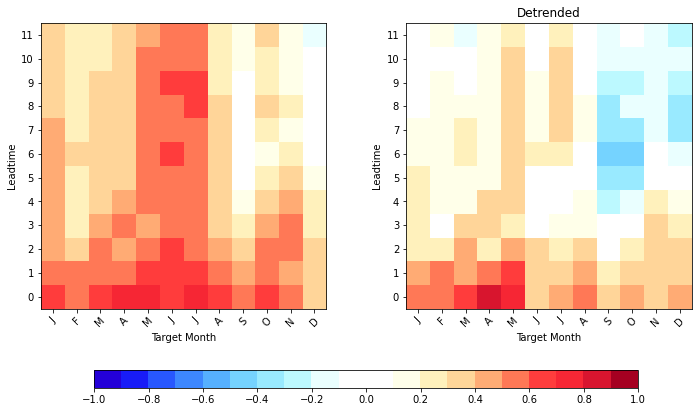

In [8]:
#configure color stuff
ACCcolors = loadmat('cmap_jet3.mat')['cmap']
cmap = colors.ListedColormap(ACCcolors, name='jet3')
bounds = np.linspace(-1,1,cmap.N+1)
norm = colors.BoundaryNorm(bounds, cmap.N)

#plot
fig,axis = plt.subplots(1,2, figsize=(12,7.5))

image0=axis[0].imshow(skillmatrix1, cmap=cmap, norm=norm)
axis[0].set_xticks(np.arange(0,12,1))
axis[0].set_yticks(np.arange(0,12,1))
axis[0].set_xticklabels(monthsnam, rotation=45)
axis[0].set_xlabel("Target Month")
axis[0].set_ylabel("Leadtime")
axis[0].invert_yaxis()

image1=axis[1].imshow(skillmatrix_dt1, cmap=cmap, norm=norm)
axis[1].set_xticks(np.arange(0,12,1))
axis[1].set_yticks(np.arange(0,12,1))
axis[1].set_xticklabels(monthsnam, rotation=45)
axis[1].set_xlabel("Target Month")
axis[1].set_ylabel("Leadtime")
axis[1].invert_yaxis()
axis[1].set_title("Detrended")

cticks = np.arange(-1,1.2,0.2)
sfactor = 6.5/8
fig.colorbar(image0, ax=[axis[0],axis[1]], shrink=sfactor, ticks=cticks, orientation=1, aspect=30)
plt.show()

# CanCM4i

In [9]:
skillmatrix = np.array([np.zeros(12) for i in range(12)]) #12x12 matrix

for tmonth in monthsind: #observation month aka target month
    for lead in monthsind: #leadtime
        
        #calculate the initialization month, given the target month and leadtime
        #(a.k.a., SIT month)
        im = tmonth - lead
        if im < 0:
            im += 12
        
        #collect data
        obs_data = DataForMonth(Had2CISdata, tmonth+1)
        sit_data = DataForMonth(SITdata_CanCM4, im+1)
        
        #make sure time of thickness data always preceeds time of observed data
        if tmonth < im:
            obs_data = np.delete(obs_data, 0)
            sit_data = np.delete(sit_data, -1)
            
        #calculate skill
        skill = np.corrcoef(obs_data,sit_data)[0,1]
        
        skillmatrix[lead,tmonth] = skill

In [10]:
#repeat but detrend now

skillmatrix_dt = np.array([np.zeros(12) for i in range(12)]) #12x12 matrix
sigmatrix_dt = np.array([np.zeros(12) for i in range(12)]) 

for tmonth in monthsind: #observation month aka target month
    for lead in monthsind: #leadtime
        
        #calculate the initialization month, given the target month and leadtime
        #(a.k.a., SIT month)
        im = tmonth - lead
        if im < 0:
            im += 12
        
        #collect data
        obs_data = Remove_Trend(DataForMonth(Had2CISdata, tmonth+1))
        sit_data = Remove_Trend(DataForMonth(SITdata_CanCM4, im+1))
        
        #make sure time of thickness data always preceeds time of observed data
        if tmonth < im:
            obs_data = np.delete(obs_data, 0)
            sit_data = np.delete(sit_data, -1)
            
        #calculate skill
        skill_dt = np.corrcoef(obs_data,sit_data)[0,1]
        skill_sign = skill_dt / abs(skill_dt)
        
        #significance
        ACCs = Bootstrap(obs_data, sit_data)
        sig_value = Confidence_Test(ACCs,sign=skill_sign)
        if skill_dt < 0 and sig_value == 1:
            sig_value -= 10
        
        skillmatrix_dt[lead,tmonth] = skill_dt
        sigmatrix_dt[lead,tmonth] = sig_value
        
sigmatrix_dt2 = np.copy(sigmatrix_dt)      
skillmatrix2 = np.copy(skillmatrix)
skillmatrix_dt2 = np.copy(skillmatrix_dt)

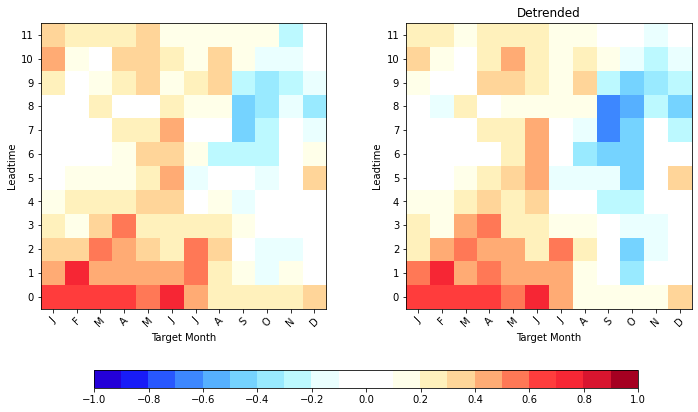

In [11]:
#configure color stuff
ACCcolors = loadmat('cmap_jet3.mat')['cmap']
cmap = colors.ListedColormap(ACCcolors, name='jet3')
bounds = np.linspace(-1,1,cmap.N+1)
norm = colors.BoundaryNorm(bounds, cmap.N)

#plot
fig,axis = plt.subplots(1,2, figsize=(12,7.5))

image0=axis[0].imshow(skillmatrix2, cmap=cmap, norm=norm)
axis[0].set_xticks(np.arange(0,12,1))
axis[0].set_yticks(np.arange(0,12,1))
axis[0].set_xticklabels(monthsnam, rotation=45)
axis[0].set_xlabel("Target Month")
axis[0].set_ylabel("Leadtime")
axis[0].invert_yaxis()

image1=axis[1].imshow(skillmatrix_dt2, cmap=cmap, norm=norm)
axis[1].set_xticks(np.arange(0,12,1))
axis[1].set_yticks(np.arange(0,12,1))
axis[1].set_xticklabels(monthsnam, rotation=45)
axis[1].set_xlabel("Target Month")
axis[1].set_ylabel("Leadtime")
axis[1].invert_yaxis()
axis[1].set_title("Detrended")

cticks = np.arange(-1,1.2,0.2)
sfactor = 6.5/8
fig.colorbar(image0, ax=[axis[0],axis[1]], shrink=sfactor, ticks=cticks, orientation=1, aspect=30)
plt.show()

# CanESM5

In [12]:
#different time interval
startyear = 1981
endyear = 2010
timeseries = np.arange(startyear, endyear + 1, 1) #yearly
timeseries_cont = np.arange(startyear, endyear + 1, 1/12) #monthly

Had2CISdata = retrievedat("Had2CISdat")
SITdata_CanESM5 = retrievedat("initialSIT_CanESM5",'CanESMSIT')

In [13]:
skillmatrix = np.array([np.zeros(12) for i in range(12)]) #12x12 matrix

for tmonth in monthsind: #observation month aka target month
    for lead in monthsind: #leadtime
        
        #calculate the initialization month, given the target month and leadtime
        #(a.k.a., SIT month)
        im = tmonth - lead
        if im < 0:
            im += 12
        
        #collect data
        obs_data = DataForMonth(Had2CISdata, tmonth+1)
        sit_data = DataForMonth(SITdata_CanESM5, im+1)
        
        #make sure time of thickness data always preceeds time of observed data
        if tmonth < im:
            obs_data = np.delete(obs_data, 0)
            sit_data = np.delete(sit_data, -1)
            
        #calculate skill
        skill = np.corrcoef(obs_data,sit_data)[0,1]
        
        skillmatrix[lead,tmonth] = skill

In [14]:
skillmatrix_dt = np.array([np.zeros(12) for i in range(12)]) #12x12 matrix
sigmatrix_dt = np.array([np.zeros(12) for i in range(12)]) 

for tmonth in monthsind: #observation month aka target month
    for lead in monthsind: #leadtime
        
        #calculate the initialization month, given the target month and leadtime
        #(a.k.a., SIT month)
        im = tmonth - lead
        if im < 0:
            im += 12
        
        #collect data
        obs_data = Remove_Trend(DataForMonth(Had2CISdata, tmonth+1))
        sit_data = Remove_Trend(DataForMonth(SITdata_CanESM5, im+1))
        
        #make sure time of thickness data always preceeds time of observed data
        if tmonth < im:
            obs_data = np.delete(obs_data, 0)
            sit_data = np.delete(sit_data, -1)
            
        #calculate skill
        skill_dt = np.corrcoef(obs_data,sit_data)[0,1]
        skill_sign = skill_dt / abs(skill_dt)
        
        #significance
        ACCs = Bootstrap(obs_data, sit_data)
        sig_value = Confidence_Test(ACCs,sign=skill_sign)
        if skill_dt < 0 and sig_value == 1:
            sig_value -= 10
        
        skillmatrix_dt[lead,tmonth] = skill_dt
        sigmatrix_dt[lead,tmonth] = sig_value
        
        

sigmatrix_dt3 = np.copy(sigmatrix_dt)      
skillmatrix3 = np.copy(skillmatrix)
skillmatrix_dt3 = np.copy(skillmatrix_dt)

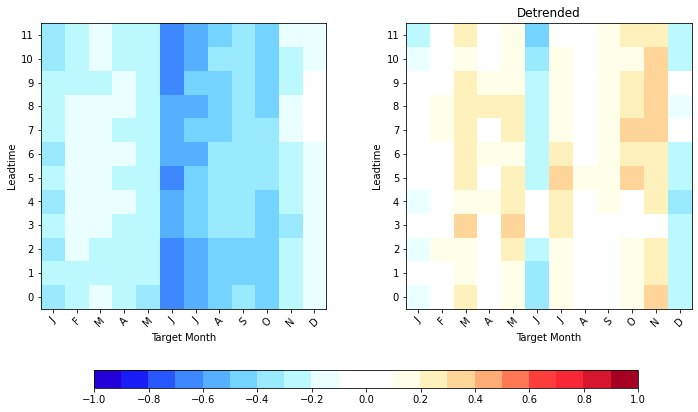

In [15]:
#configure color stuff
ACCcolors = loadmat('cmap_jet3.mat')['cmap']
cmap = colors.ListedColormap(ACCcolors, name='jet3')
bounds = np.linspace(-1,1,cmap.N+1)
norm = colors.BoundaryNorm(bounds, cmap.N)

#plot
fig,axis = plt.subplots(1,2, figsize=(12,7.5))

image0=axis[0].imshow(skillmatrix3, cmap=cmap, norm=norm)
axis[0].set_xticks(np.arange(0,12,1))
axis[0].set_yticks(np.arange(0,12,1))
axis[0].set_xticklabels(monthsnam, rotation=45)
axis[0].set_xlabel("Target Month")
axis[0].set_ylabel("Leadtime")
axis[0].invert_yaxis()

image1=axis[1].imshow(skillmatrix_dt3, cmap=cmap, norm=norm)
axis[1].set_xticks(np.arange(0,12,1))
axis[1].set_yticks(np.arange(0,12,1))
axis[1].set_xticklabels(monthsnam, rotation=45)
axis[1].set_xlabel("Target Month")
axis[1].set_ylabel("Leadtime")
axis[1].invert_yaxis()
axis[1].set_title("Detrended")

cticks = np.arange(-1,1.2,0.2)
sfactor = 6.5/8
fig.colorbar(image0, ax=[axis[0],axis[1]], shrink=sfactor, ticks=cticks, orientation=1, aspect=30)
plt.show()

# Figure for the paper

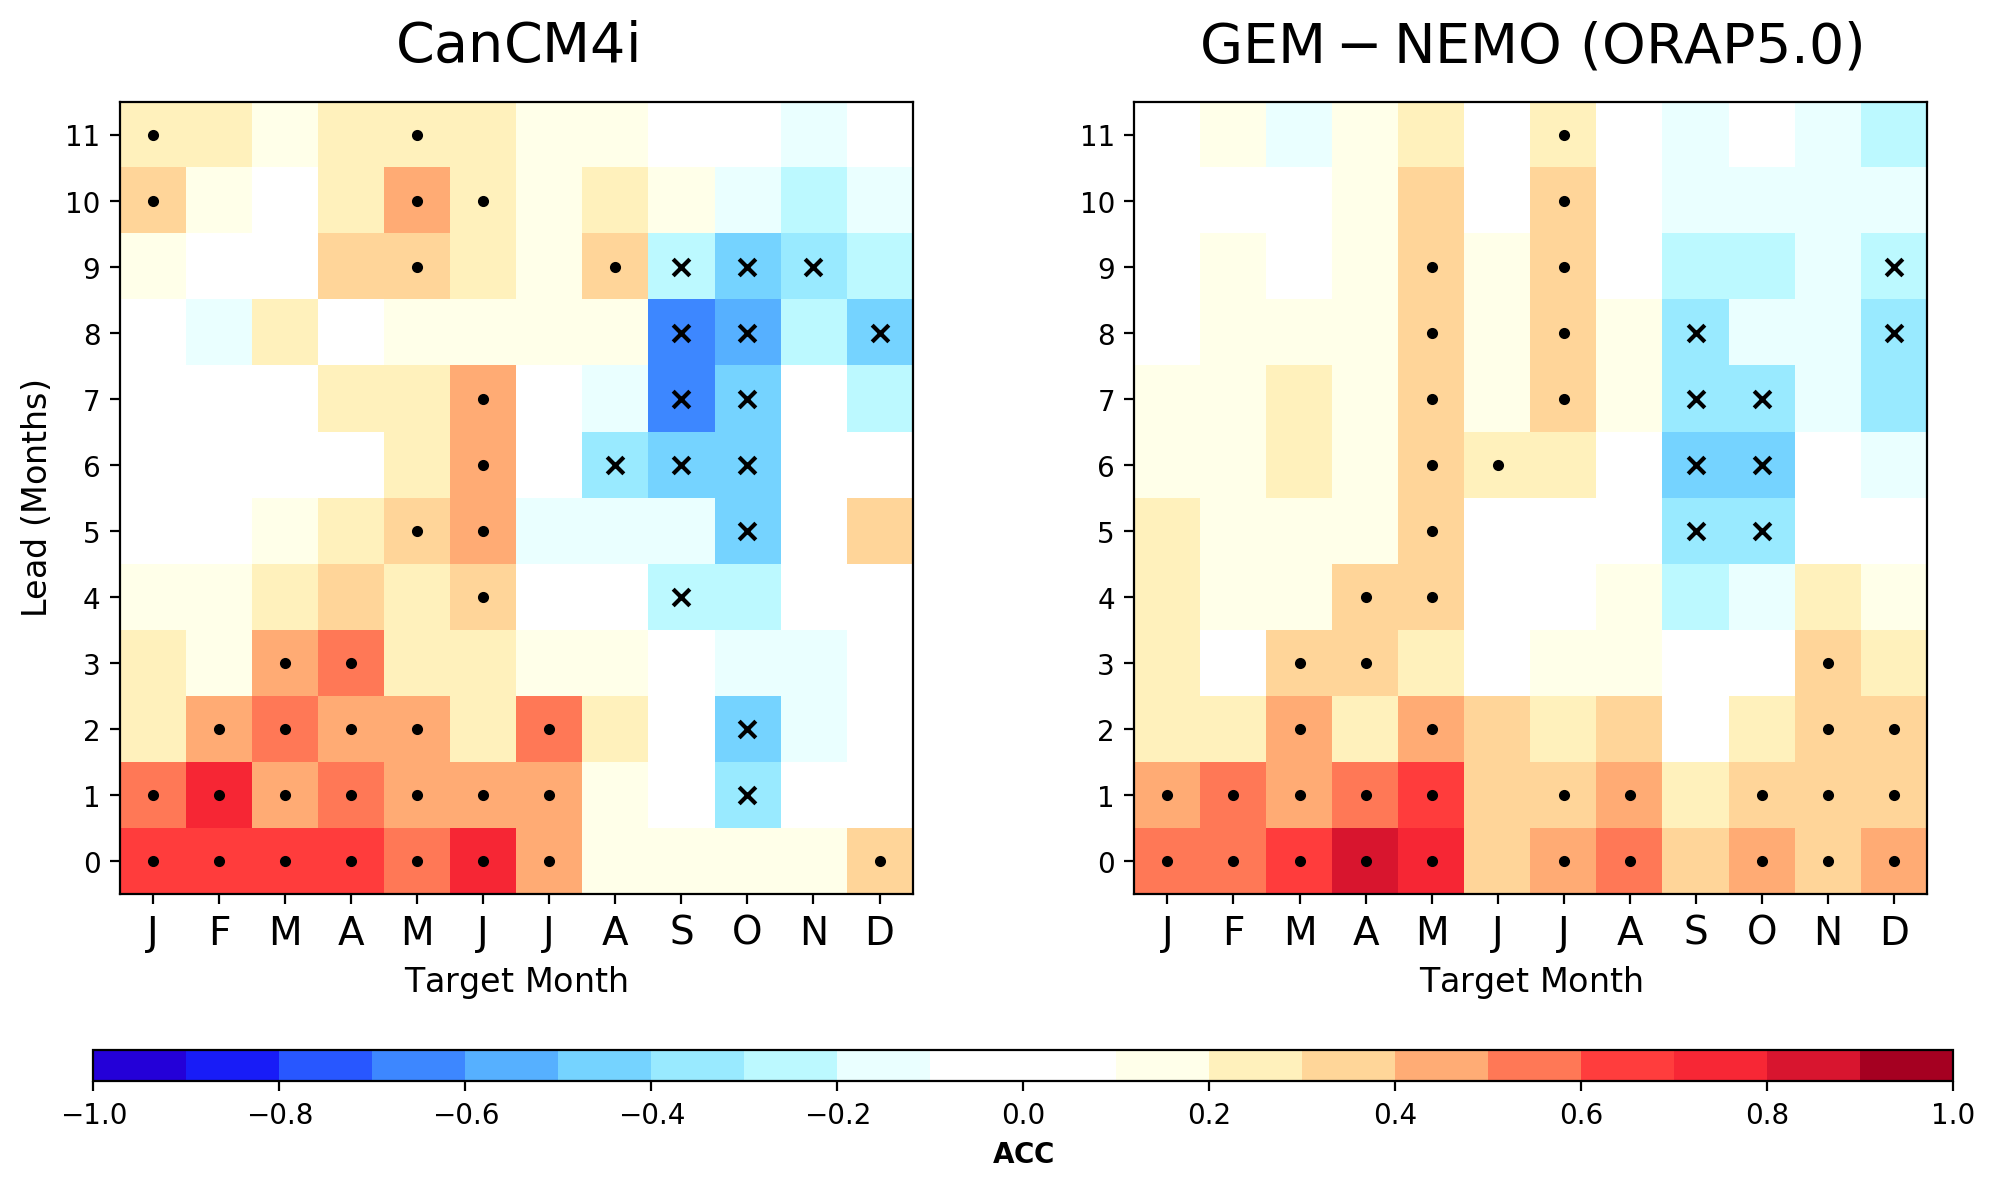

In [16]:
#configure color stuff
ACCcolors = loadmat('cmap_jet3.mat')['cmap']
cmap = colors.ListedColormap(ACCcolors, name='jet3')
bounds = np.linspace(-1,1,cmap.N+1)
norm = colors.BoundaryNorm(bounds, cmap.N)

#plot
fig,axis = plt.subplots(1,2, figsize=(12,7.5), facecolor='white',dpi=200)

image0=axis[0].imshow(skillmatrix_dt2, cmap=cmap, norm=norm)
axis[0].set_xticks(np.arange(0,12,1))
axis[0].set_yticks(np.arange(0,12,1))
axis[0].set_xticklabels(monthsnam, rotation=0, size=14)
axis[0].set_ylabel(r"$\mathrm{Lead\ (Months)}$", size=12)
axis[0].invert_yaxis()
axis[0].set_title(r"$\mathrm{CanCM4i}$", size=20, y=1.03)
axis[0].set_xlabel(r"$\mathrm{Target\ Month}$", size=12)

image1=axis[1].imshow(skillmatrix_dt1, cmap=cmap, norm=norm)
axis[1].set_xticks(np.arange(0,12,1))
axis[1].set_yticks(np.arange(0,12,1))
axis[1].set_xticklabels(monthsnam, rotation=0, size=14)
axis[1].set_xlabel(r"$\mathrm{Target\ Month}$", size=12)
axis[1].invert_yaxis()
axis[1].set_title(r"$\mathrm{GEM-NEMO\ (ORAP5.0)}$", size=20, y=1.03)

Plot_Significance_Matrix(sigmatrix_dt2,0)
Plot_Significance_Matrix(sigmatrix_dt1,1)

cticks = np.arange(-1,1.2,0.2)
axislist=(axis[0],axis[1])
hm2 = fig.colorbar(image0, ax=axislist, location='bottom', shrink=1, ticks=cticks, label=r'$\mathbf{ACC}$', aspect=60, anchor=(0,1.1))
#plt.savefig("SITinitialization.png",facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

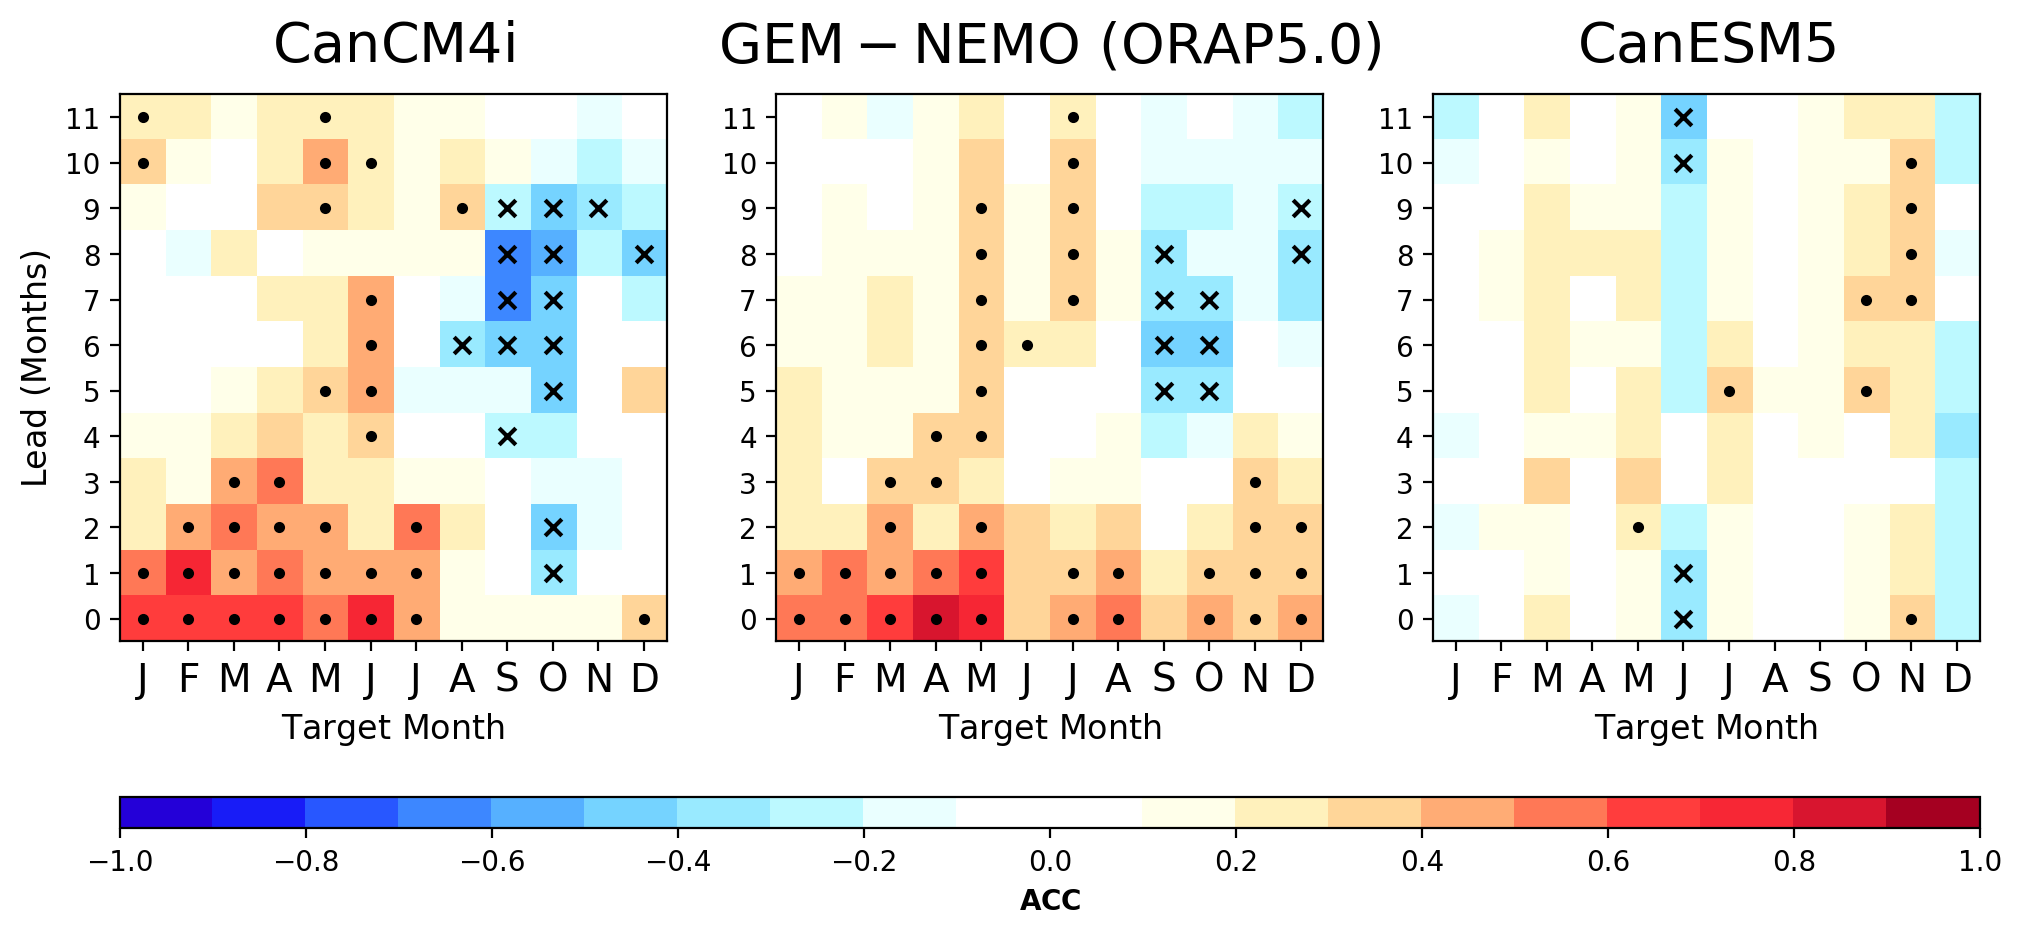

In [17]:
#configure color stuff
ACCcolors = loadmat('cmap_jet3.mat')['cmap']
cmap = colors.ListedColormap(ACCcolors, name='jet3')
bounds = np.linspace(-1,1,cmap.N+1)
norm = colors.BoundaryNorm(bounds, cmap.N)

#plot
fig,axis = plt.subplots(1,3, figsize=(12,7.5), facecolor='white',dpi=200)

image0=axis[0].imshow(skillmatrix_dt2, cmap=cmap, norm=norm)
axis[0].set_xticks(np.arange(0,12,1))
axis[0].set_yticks(np.arange(0,12,1))
axis[0].set_xticklabels(monthsnam, rotation=0, size=14)
axis[0].set_ylabel(r"$\mathrm{Lead\ (Months)}$", size=12)
axis[0].invert_yaxis()
axis[0].set_title(r"$\mathrm{CanCM4i}$", size=20, y=1.03)
axis[0].set_xlabel(r"$\mathrm{Target\ Month}$", size=12)

image1=axis[1].imshow(skillmatrix_dt1, cmap=cmap, norm=norm)
axis[1].set_xticks(np.arange(0,12,1))
axis[1].set_yticks(np.arange(0,12,1))
axis[1].set_xticklabels(monthsnam, rotation=0, size=14)
axis[1].set_xlabel(r"$\mathrm{Target\ Month}$", size=12)
axis[1].invert_yaxis()
axis[1].set_title(r"$\mathrm{GEM-NEMO\ (ORAP5.0)}$", size=20, y=1.03)

image2=axis[2].imshow(skillmatrix_dt3, cmap=cmap, norm=norm)
axis[2].set_xticks(np.arange(0,12,1))
axis[2].set_yticks(np.arange(0,12,1))
axis[2].set_xticklabels(monthsnam, rotation=0, size=14)
axis[2].invert_yaxis()
axis[2].set_title(r"$\mathrm{CanESM5}$", size=20, y=1.03)
axis[2].set_xlabel(r"$\mathrm{Target\ Month}$", size=12)

Plot_Significance_Matrix(sigmatrix_dt2,0)
Plot_Significance_Matrix(sigmatrix_dt1,1)
Plot_Significance_Matrix(sigmatrix_dt3,2)

cticks = np.arange(-1,1.2,0.2)
axislist=(axis[0],axis[1],axis[2])
hm2 = fig.colorbar(image0, ax=axislist, location='bottom', shrink=1, ticks=cticks, label=r'$\mathbf{ACC}$', aspect=60, anchor=(0,1.1))
plt.savefig("SITinitialization.png",facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

# Spatial Distribution of Initial Conditions

In [18]:
def plot_init_SIT (year, im):
    
    #retrieve relevant data
    filename = "sf_chfp3b-hindcast_198101-202012_init_1x1_sithick.nc"
    file = nc.Dataset(filename,'r')
    SITfield = file.variables['sithick'][:][(year - 1981)*12 + (im-1)]
    lon = file.variables['lon'][:]
    lat = file.variables['lat'][:]
    file.close()
    
    #create plot
    proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines()
    ax.set_title("Initial SIT, " + months[im] + " " + str(year), size=20)

    #focus in on Antarctic
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    #circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    #plot the data
    contour = ax.contourf(lon, lat, SITfield, vmin=0,vmax=5,transform=ccrs.PlateCarree())

    #plot boundaries between regions
    ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    
    #label regions
    ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
    ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
    ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
    ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
    ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

    #colorbar
    cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.7)
    cbar.set_label('SIT [m]',size=20)

    plt.show()

<ipython-input-18-3429c6e43435>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SITfield = file.variables['sithick'][:][(year - 1981)*12 + (im-1)]
<ipython-input-18-3429c6e43435>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['lon'][:]
<ipython-input-18-3429c6e43435>:8: DeprecationWarning: `np.bool` is a deprecated alias for

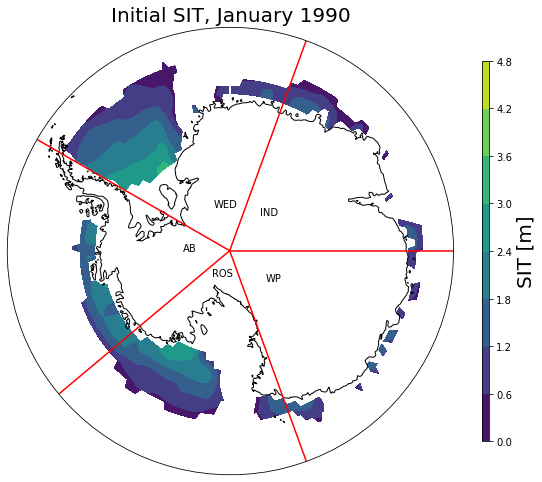

In [19]:
plot_init_SIT(1990,1)

# SIC initial conditions

In [20]:
filen = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
file = nc.Dataset(filen,'r')
SIC = file.variables['SICN'][:]
print(np.shape(SIC))
file.close()

<ipython-input-20-e8b7dac73a82>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SIC = file.variables['SICN'][:]


(492, 10, 180, 360)


In [21]:
def plot_init_SIC (year, im):
    
    #retrieve relevant data
    if im == 1:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
    else:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m" + monthsstr[im-1] + "_2021_m" + monthsstr[im-2] + "_ens10_sicn.nc"
    file = nc.Dataset(filename,'r')
    SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
    lon = file.variables['longitude'][:]
    lat = file.variables['latitude'][:]
    file.close()
    
    #rid of bad values
    SICfield[SICfield > 1] = np.nan
    
    #create plot
    proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines()
    ax.set_title("Lead-0 SIC, " + months[im] + " " + str(year), size=20)

    #focus in on Antarctic
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    #circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    #plot the data
    contour = ax.contourf(lon, lat, SICfield, vmin=0,vmax=1,transform=ccrs.PlateCarree())

    #plot boundaries between regions
    ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    
    #label regions
    ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
    ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
    ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
    ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
    ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

    #colorbar
    cticks = np.arange(0,1.1,0.1)
    cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.7,ticks=cticks)
    cbar.set_label('SIC',size=20)

    plt.show()

### - Different time period than initial SIT?
### - There aren't any SIC>1 in spite of the colour bar, I checked.
### - Large decrease in lead-0 january SIC after 2016 event

# Both at same time (SIT and SIC)

In [22]:
def plot_init(year, im):
    
    #SIC starts 1980, SIT starts 1981
    
    #retrieve initial SIC
    if im == 1:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
    else:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m" + monthsstr[im-1] + "_2021_m" + monthsstr[im-2] + "_ens10_sicn.nc"
    file = nc.Dataset(filename,'r')
    SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
    lon = file.variables['longitude'][:]
    lat = file.variables['latitude'][:]
    file.close()
    SICfield[SICfield > 1] = np.nan
    
    #retrieve initial SIT
    filename = "sf_chfp3b-hindcast_198101-202012_init_1x1_sithick.nc"
    file = nc.Dataset(filename,'r')
    SITfield = file.variables['sithick'][:][(year - 1981)*12 + (im-1)]
    lon2 = file.variables['lon'][:]
    lat2 = file.variables['lat'][:]
    file.close()
    
    #plot
    proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
    fig = plt.figure(figsize=(16,20))
    ax = fig.add_subplot(221, projection=proj)
    ax2 = fig.add_subplot(222, projection=proj)
    ax.coastlines()
    ax2.coastlines()
    ax.set_title("Lead-0 SIC, " + months[im] + " " + str(year), size=20)
    ax2.set_title("Initial SIT, " + months[im] + " " + str(year), size=20)

    #focus in on Antarctic
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax2.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    #circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax2.set_boundary(circle, transform=ax2.transAxes)

    #plot the data
    contour = ax.contourf(lon, lat, SICfield, vmin=0,vmax=1,transform=ccrs.PlateCarree())
    contour2 = ax2.contourf(lon2, lat2, SITfield, vmin=0,vmax=4,transform=ccrs.PlateCarree())

    #plot boundaries between regions
    ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    
    #label regions
    ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
    ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
    ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
    ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
    ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())
    ax2.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
    ax2.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
    ax2.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
    ax2.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
    ax2.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

    #colorbar
    cticks = np.arange(0,1.1,0.1)
    cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.5,ticks=cticks)
    cbar2 = fig.colorbar(contour2, ax=ax2,aspect=50,shrink=0.5)
    cbar.set_label('SIC',size=20)
    cbar2.set_label("SIT [M]",size=20)

    plt.show()

<ipython-input-22-90de3b898c57>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-22-90de3b898c57>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-22-90de3b898c57>:13: DeprecationWarning: `np.bool` is a deprecated alias for

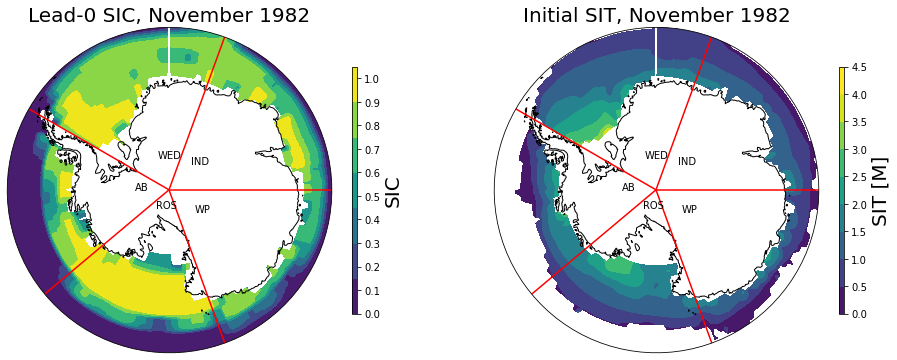

In [23]:
plot_init(1982,11)

<ipython-input-22-90de3b898c57>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-22-90de3b898c57>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-22-90de3b898c57>:13: DeprecationWarning: `np.bool` is a deprecated alias for

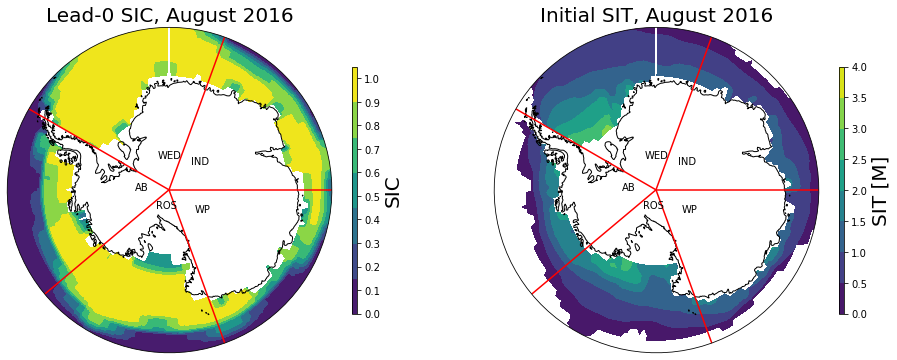

In [24]:
plot_init(2016,8)

### - There appears to be SIT even where SIC is 0.

# SIT Anomalies

In [25]:
filename = "sf_chfp3b-hindcast_198101-202012_init_1x1_sithick.nc"
file = nc.Dataset(filename,'r')
SITfield = file.variables['sithick'][:]
file.close()

print(np.shape(SITfield))

(480, 180, 360)


<ipython-input-25-265cfecd17b6>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SITfield = file.variables['sithick'][:]


In [26]:
#Array of monthly SIT averages, shape 180x360x12
meanSITfield = np.full((360,180,12),np.nan)
SITfieldT = np.transpose(SITfield)

#select grid cell
for i in range(360):
    
    #progress tracker
    if (i+1)%60 == 0:
        print(i+1)
    
    for j in range(180):
        
        #select month of interest
        for m in monthsnum:
            
            dataformonth = DataForMonth(SITfieldT[i][j],m,1)
            av = average(dataformonth)
            meanSITfield[i][j][m-1] = av
            
meanSITfield[np.abs(meanSITfield)>1e10] = 0

60
120
180
240
300
360


<ipython-input-27-7a75ea066146>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['lon'][:]
<ipython-input-27-7a75ea066146>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = file.variables['lat'][:]


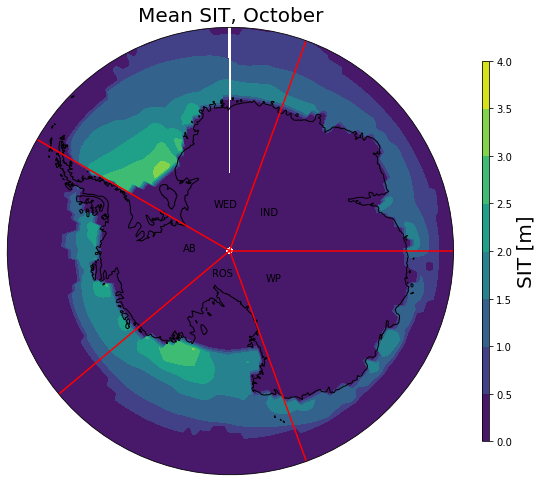

In [27]:
#month
mn = 10

#retrieve initial SIT
filename = "sf_chfp3b-hindcast_198101-202012_init_1x1_sithick.nc"
file = nc.Dataset(filename,'r')
lon = file.variables['lon'][:]
lat = file.variables['lat'][:]
file.close()

#create plot
proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_title("Mean SIT, " + months[mn], size=20)

#focus in on Antarctic
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#circular boundary
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], .5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#plot the data
contour = ax.contourf(lon, lat, np.transpose(meanSITfield)[mn],vmin=0,vmax=4,transform=ccrs.PlateCarree())

#plot boundaries between regions
ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())

#label regions
ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

#colorbar
cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.7)
cbar.set_label('SIT [m]',size=20)

plt.show()

<ipython-input-22-90de3b898c57>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-22-90de3b898c57>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-22-90de3b898c57>:13: DeprecationWarning: `np.bool` is a deprecated alias for

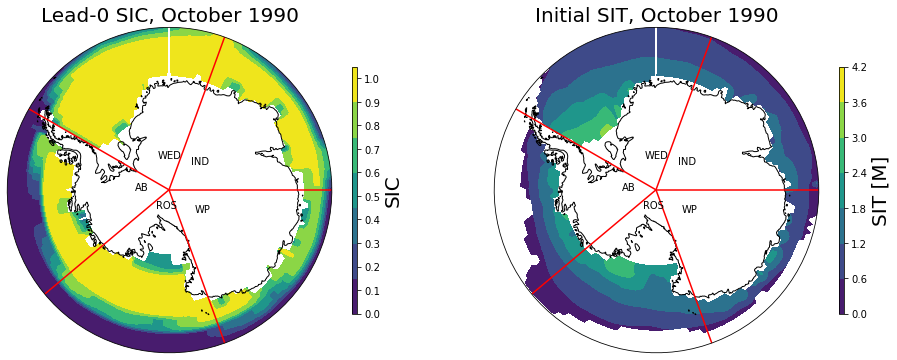

In [28]:
plot_init(1990,10)

In [29]:
#anomalize SIT field

SITfield_anom = []

for ti in range(480):
    
    #check progress
    if (ti+1)%60 == 0:
        print(ti+1)
        
    #the relevant SIT field
    SITmatrix = SITfield[ti]
    
    #the mean SIT field for that month
    meanSITmatrix = np.transpose(meanSITfield)[ti%12]
    
    #calculate anomaly
    SITanomalymatrix = SITmatrix - meanSITmatrix
    
    #store in array
    SITfield_anom.append( SITanomalymatrix )
    
save('SITfield_anomalies.npy', SITfield_anom)

60
120
180
240
300
360
420
480


# SIC Anomalies

In [30]:
filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
file = nc.Dataset(filename,'r')
SICfield = file.variables['SICN'][:]
print(np.shape(SICfield))
print(np.shape(np.transpose(SICfield)))
file.close()

<ipython-input-30-f061c6dbceb1>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:]


(492, 10, 180, 360)
(360, 180, 10, 492)


In [31]:
meanSICfield = np.full((360,180,12),np.nan)

#select month
for im in monthsnum:

    #progress tracker
    print(im)
    
    #open relevant file and get the SIC data
    if im == 1:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
    else:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m" + monthsstr[im-1] + "_2021_m" + monthsstr[im-2] + "_ens10_sicn.nc"
    file = nc.Dataset(filename,'r')
    SICfieldT = np.transpose(file.variables['SICN'][:])
    file.close()
    
    #select grid cell:
    for i in range(360):
        for j in range(180):
            
            #get all the data for that month
            dataformonth = DataForMonth(SICfieldT[i][j][0],im,im)
            
            #get average
            av = average(dataformonth)
            
            #store in array
            meanSICfield[i][j][im-1] = av
            
meanSICfield[meanSICfield > 1] = 0

1


<ipython-input-31-32046ad0d1c5>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfieldT = np.transpose(file.variables['SICN'][:])


2


<ipython-input-31-32046ad0d1c5>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfieldT = np.transpose(file.variables['SICN'][:])


3
4
5
6
7
8
9
10
11
12


<ipython-input-32-1ce7ad6e8b26>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-32-1ce7ad6e8b26>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = file.variables['latitude'][:]


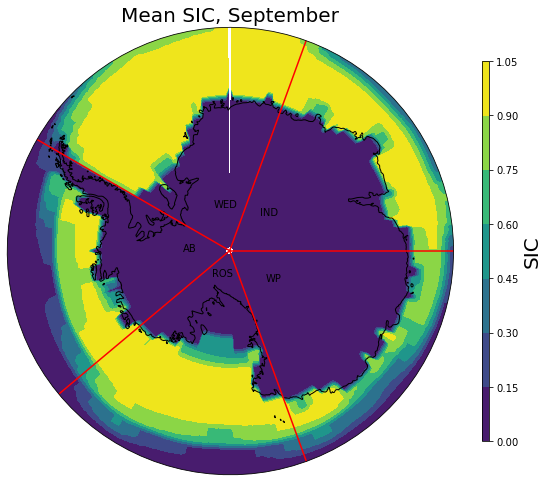

In [32]:
#month
mn = 9

#retrieve initial SIT
filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
file = nc.Dataset(filename,'r')
lon = file.variables['longitude'][:]
lat = file.variables['latitude'][:]
file.close()

#create plot
proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_title("Mean SIC, " + months[mn], size=20)

#focus in on Antarctic
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#circular boundary
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], .5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#plot the data
contour = ax.contourf(lon, lat, np.transpose(meanSICfield)[mn-1],vmin=0,vmax=1,transform=ccrs.PlateCarree())

#plot boundaries between regions
ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())

#label regions
ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

#colorbar
cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.7)
cbar.set_label('SIC',size=20)

plt.show()

<ipython-input-33-d1e910d4eff0>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-33-d1e910d4eff0>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = file.variables['latitude'][:]


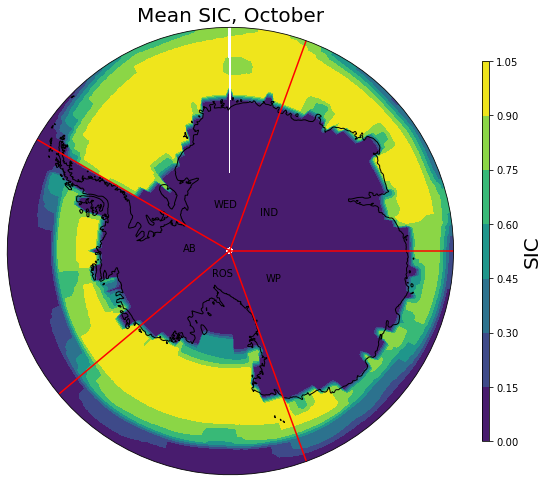

In [33]:
#month
mn = 10

#retrieve initial SIT
filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
file = nc.Dataset(filename,'r')
lon = file.variables['longitude'][:]
lat = file.variables['latitude'][:]
file.close()

#create plot
proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_title("Mean SIC, " + months[mn], size=20)
#focus in on Antarctic
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#circular boundary
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], .5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#plot the data
contour = ax.contourf(lon, lat, np.transpose(meanSICfield)[mn-1],vmin=0,vmax=1,transform=ccrs.PlateCarree())

#plot boundaries between regions
ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())

#label regions
ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

#colorbar
cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.7)
cbar.set_label('SIC',size=20)

plt.show()

<ipython-input-34-3a2d35fb2963>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-34-3a2d35fb2963>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = file.variables['latitude'][:]


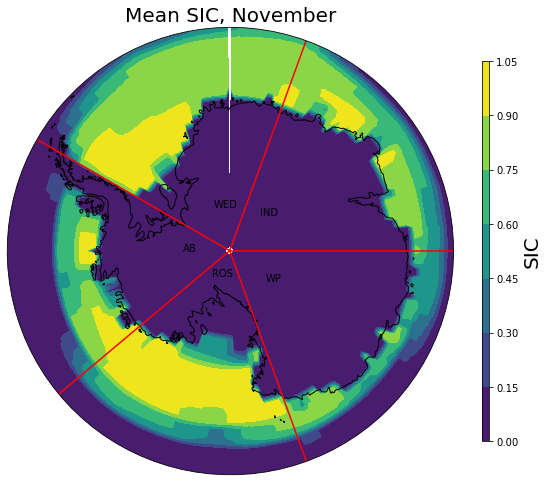

In [34]:
#month
mn = 11

#retrieve initial SIT
filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
file = nc.Dataset(filename,'r')
lon = file.variables['longitude'][:]
lat = file.variables['latitude'][:]
file.close()

#create plot
proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_title("Mean SIC, " + months[mn], size=20)

#focus in on Antarctic
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#circular boundary
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], .5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#plot the data
contour = ax.contourf(lon, lat, np.transpose(meanSICfield)[mn-1],vmin=0,vmax=1,transform=ccrs.PlateCarree())

#plot boundaries between regions
ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())

#label regions
ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

#colorbar
cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.7)
cbar.set_label('SIC',size=20)

plt.show()

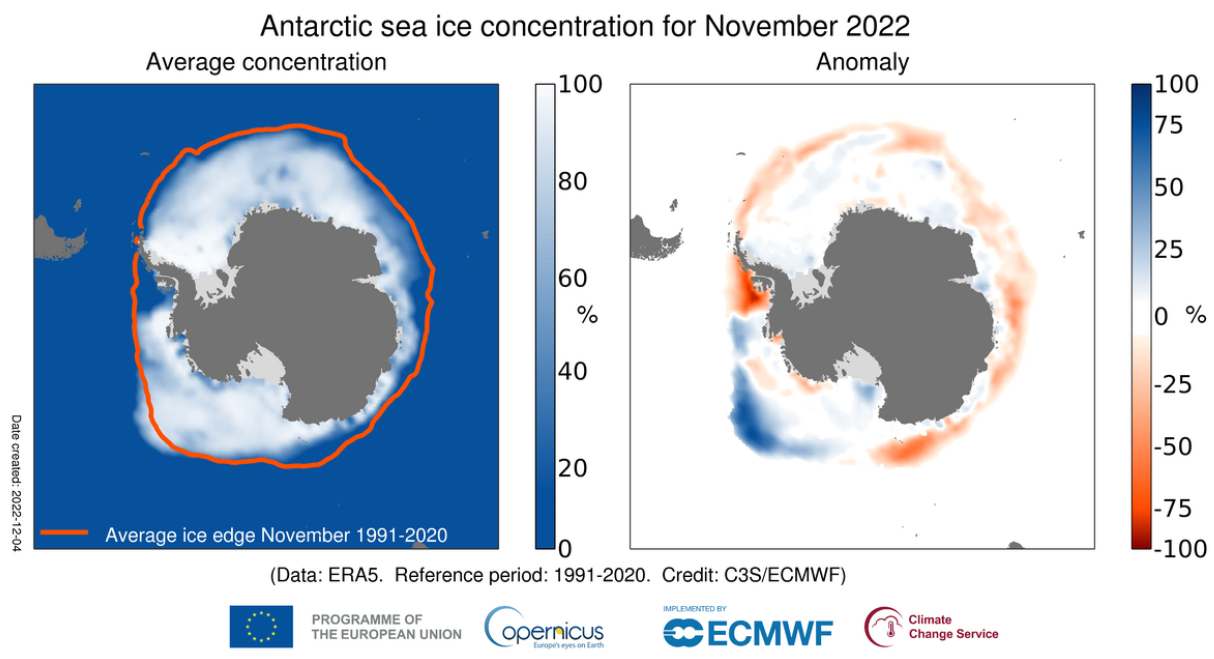

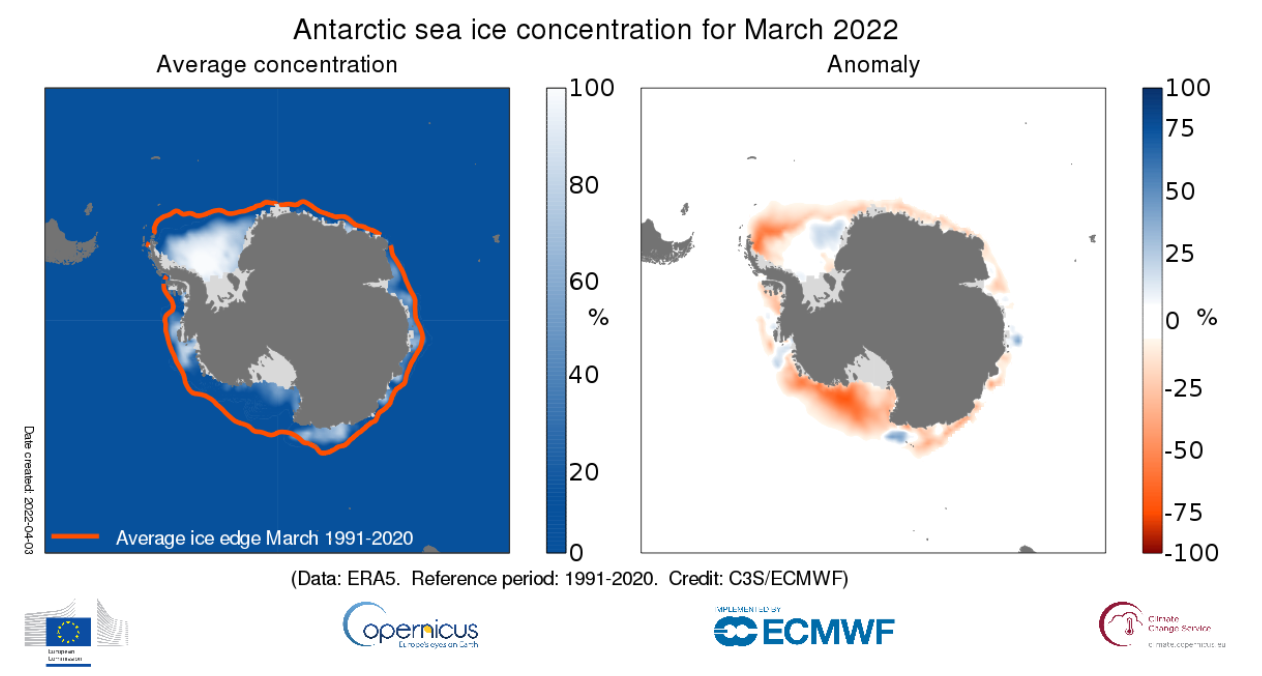

<ipython-input-21-4de4c56e7993>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-21-4de4c56e7993>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-21-4de4c56e7993>:11: DeprecationWarning: `np.bool` is a deprecated alias for 

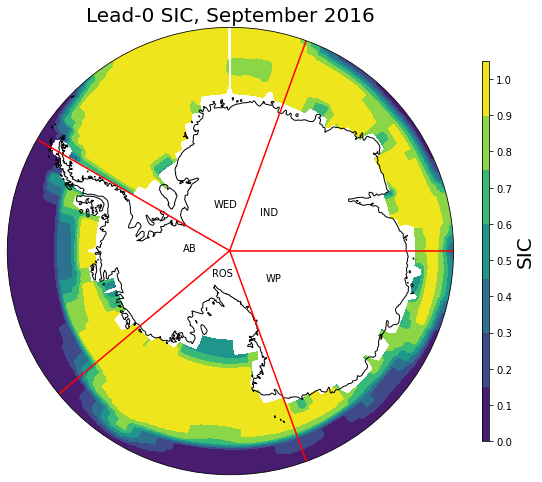

In [35]:
plot_init_SIC(2016,9)

<ipython-input-21-4de4c56e7993>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-21-4de4c56e7993>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-21-4de4c56e7993>:11: DeprecationWarning: `np.bool` is a deprecated alias for 

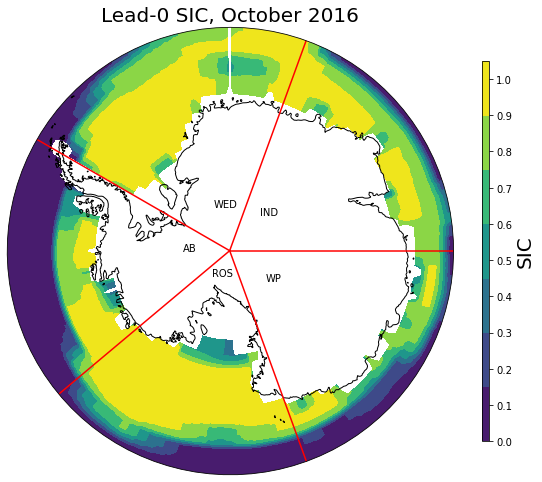

In [36]:
plot_init_SIC(2016,10)

<ipython-input-21-4de4c56e7993>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-21-4de4c56e7993>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-21-4de4c56e7993>:11: DeprecationWarning: `np.bool` is a deprecated alias for 

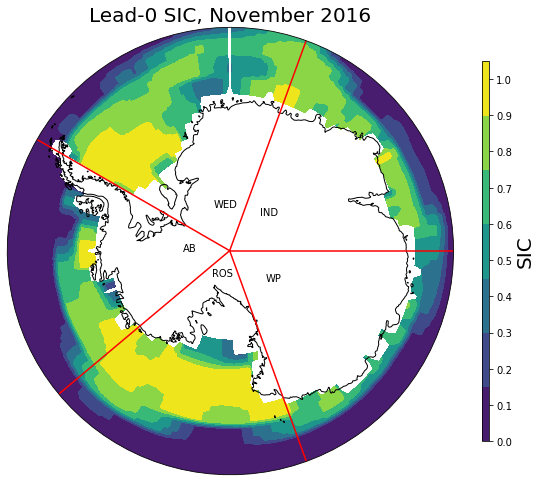

In [37]:
plot_init_SIC(2016,11)

# Plot

In [38]:
def plot_init_anom(year, im):
    
    #SIC starts 1980, SIT starts 1981
    
    #colorbar stuff part 1
    ACCcolors = loadmat('cmap_jet3.mat')['cmap']
    cmap = colors.ListedColormap(ACCcolors, name='jet3')
#     cmap = plt.get_cmap("RdBu_r")
    bounds = np.linspace(-1,1,cmap.N+1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    bounds2 = np.linspace(-4,4,cmap.N+1)
    norm2 = colors.BoundaryNorm(bounds2, cmap.N)
    
    #retrieve initial SIC anomaly
    if im == 1:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc"
    else:
        filename = "CanESMData/sf_chfp3b_1x1_1980_m" + monthsstr[im-1] + "_2021_m" + monthsstr[im-2] + "_ens10_sicn.nc"
    file = nc.Dataset(filename,'r')
    SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
    lon = file.variables['longitude'][:]
    lat = file.variables['latitude'][:]
    file.close()
    SICfield[SICfield > 1] = np.nan
    
    SICfieldanom = SICfield - np.transpose(meanSICfield)[im-1]
    
    #retrieve initial SIT anomaly
    filename = "sf_chfp3b-hindcast_198101-202012_init_1x1_sithick.nc"
    file = nc.Dataset(filename,'r')
    lon2 = file.variables['lon'][:]
    lat2 = file.variables['lat'][:]
    file.close()
    
    file = load('SITfield_anomalies.npy')
    SITfieldanom = file[(year - 1981)*12 + (im-1)]
    SITfieldanom[np.abs(SITfieldanom) > 3] = np.nan
    
    #plot
    proj = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
    fig = plt.figure(figsize=(16,20))
    ax = fig.add_subplot(221, projection=proj)
    ax2 = fig.add_subplot(222, projection=proj)
    ax.coastlines()
    ax2.coastlines()
    ax.set_title("Lead-0 SIC anomaly, " + months[im] + " " + str(year), size=20)
    ax2.set_title("Initial SIT anomaly, " + months[im] + " " + str(year), size=20)

    #focus in on Antarctic
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax2.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    #circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax2.set_boundary(circle, transform=ax2.transAxes)

    #plot the data
    contour = ax.contourf(lon, lat, SICfieldanom,vmin=-1,vmax=1,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
    contour2 = ax2.contourf(lon2, lat2, SITfieldanom,vmin=-3,vmax=3, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm2)


    #plot boundaries between regions
    ax.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([-60,-60],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([20,20],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([90,90],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([160,160],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    ax2.plot([-130,-130],[-90,-40],'-',color='red',transform=ccrs.PlateCarree())
    
    #label regions
    ax.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
    ax.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
    ax.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
    ax.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
    ax.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())
    ax2.text(-20,-84,'WED',color='black',transform=ccrs.PlateCarree())
    ax2.text(40,-84,'IND',color='black',transform=ccrs.PlateCarree())
    ax2.text(130,-84,'WP',color='black',transform=ccrs.PlateCarree())
    ax2.text(215,-86,'ROS',color='black',transform=ccrs.PlateCarree())
    ax2.text(270,-84,'AB',color='black',transform=ccrs.PlateCarree())

    #colorbar
    cticks = np.arange(-1,1.1,0.1)
    cbar = fig.colorbar(contour, ax=ax,aspect=50,shrink=0.5,ticks=cticks)
    cbar2 = fig.colorbar(contour2, ax=ax2,aspect=50,shrink=0.5)
    cbar.set_label('SIC anomaly',size=20)
    cbar2.set_label("SIT anomaly [m]",size=20)

    plt.show()

<ipython-input-38-54c61547b833>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-38-54c61547b833>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-38-54c61547b833>:22: DeprecationWarning: `np.bool` is a deprecated alias for

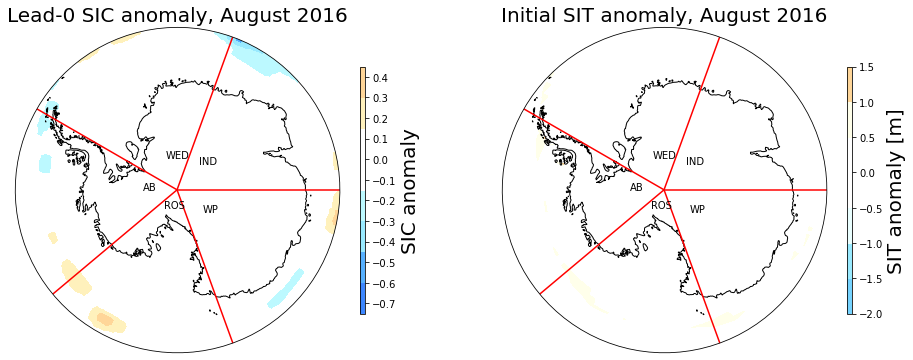

In [39]:
plot_init_anom(2016,8)

<ipython-input-38-54c61547b833>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-38-54c61547b833>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-38-54c61547b833>:22: DeprecationWarning: `np.bool` is a deprecated alias for

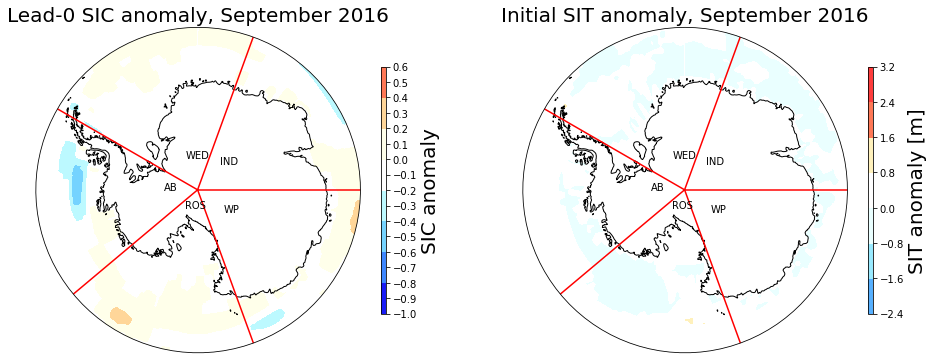

In [40]:
plot_init_anom(2016,9)

<ipython-input-38-54c61547b833>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-38-54c61547b833>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-38-54c61547b833>:22: DeprecationWarning: `np.bool` is a deprecated alias for

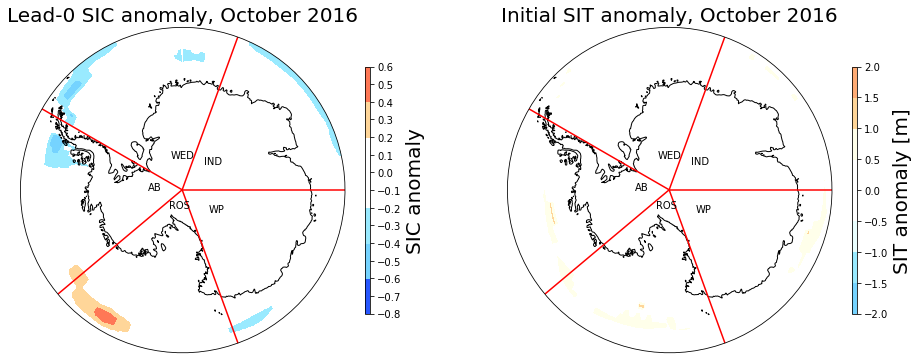

In [41]:
plot_init_anom(2016,10)

<ipython-input-38-54c61547b833>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-38-54c61547b833>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-38-54c61547b833>:22: DeprecationWarning: `np.bool` is a deprecated alias for

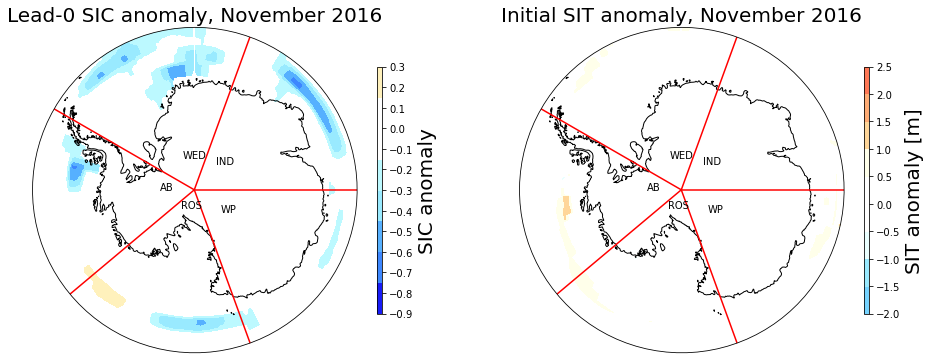

In [42]:
plot_init_anom(2016,11)

<ipython-input-38-54c61547b833>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICfield = file.variables['SICN'][:][(year - 1980)*12][0]
<ipython-input-38-54c61547b833>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = file.variables['longitude'][:]
<ipython-input-38-54c61547b833>:22: DeprecationWarning: `np.bool` is a deprecated alias for

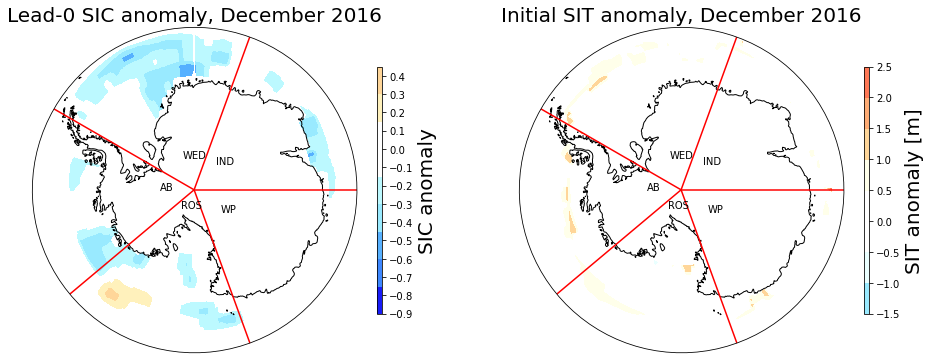

In [43]:
plot_init_anom(2016,12)

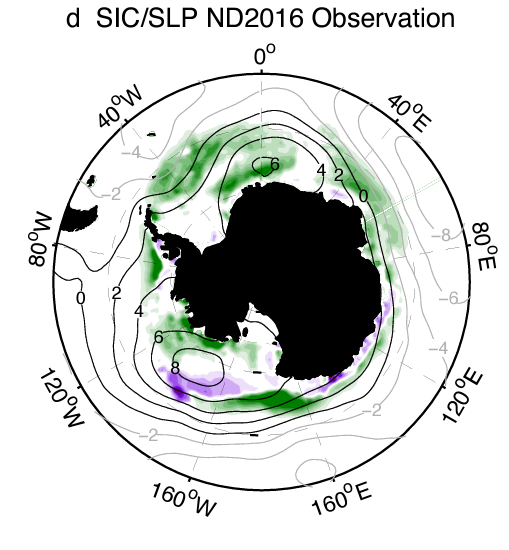